In [326]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
from harmony import harmonize
import seaborn as sns

In [300]:
@nb.njit(parallel=True)
def filter_logcounts(temp_output, logcounts, index_cells, index_genes):
    for i in nb.prange(len(index_cells)):
        temp_output[i] = logcounts[index_cells[i]][index_genes]

In [327]:
# load data
meta = np.load('./processed_data/single_cell/filtered_meta.npy', allow_pickle=True)
meta_names = np.load('./processed_data/single_cell/meta_names.npy', allow_pickle=True)
features = np.load('./processed_data/single_cell/features.npy')
counts = np.memmap('./processed_data/single_cell/filtered_counts.npy', mode='r+', shape=(meta.shape[0], features.shape[0]), dtype='int16')
index_genes = np.load('./processed_data/single_cell/marker_indices.npy')
feature_index = np.load('./processed_data/single_cell/features_proteincoding_index.npy')
projections = np.load('./processed_data/single_cell/projected_matrix.npy')
logcounts = np.memmap('./processed_data/single_cell/filtered_logcounts.npy', mode='r+', shape=counts.shape, dtype='float')

In [328]:
meta[:,0] = [meta[i,0]+'_'+str(i) for i in range(len(meta[:,0]))] 

In [329]:
# subset
index_all = meta[:,np.where(meta_names=='keep_cells_gaussian')[0][0]].astype(bool)

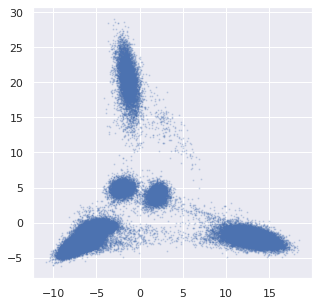

In [330]:
plt.scatter(projections[index_all,0], projections[index_all,1], s=1, alpha=0.2)

In [331]:
# get projections
projections_indexed = projections[index_all]

# metadata
meta_indexed = meta[index_all]
meta_indexed = pd.DataFrame(meta_indexed)
meta_indexed.columns = meta_names
meta_indexed.index = meta_indexed['barcodes']
meta_indexed = pd.get_dummies(meta_indexed, columns=['projid'], drop_first=True)

L = list(meta_indexed.columns[[x.split('_')[0]=='projid' for x in meta_indexed.columns]])

# perform batch correction with harmony
Z = harmonize(projections_indexed, meta_indexed, batch_key = L)

/state/partition1/slurm_tmp/23701570.0.0/ipykernel_3503891/957316070.py:9: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  meta_indexed = pd.get_dummies(meta_indexed, columns=['projid'], drop_first=True)


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


In [332]:
# get markers and filter the logcounts to only include marker gene logcounts
marker_temp = np.memmap('./processed_data/single_cell/marker_temp.npy', mode='w+', shape=(np.sum(index_all), len(index_genes)), dtype='float')
filter_logcounts(marker_temp, logcounts, np.where(index_all)[0], index_genes)

In [333]:
# make adata object

# features
FEATURES_df = pd.DataFrame(features[index_genes])
FEATURES_df.columns = ['Gene', 'ID']
FEATURES_df.index = FEATURES_df['Gene']

# counts
COUNTS_df = pd.DataFrame(marker_temp)
COUNTS_df.columns = FEATURES_df['Gene']

adata = sc.AnnData(X=COUNTS_df, obs=meta_indexed, var=FEATURES_df)
adata.obsm['X_pca'] = Z
adata.var_names_make_unique(join='.')
adata.obs_names_make_unique(join='.')

In [334]:
# compute neighborhood graph and perform leiden clustering
print('neighborhood graph')
sc.pp.neighbors(adata, use_rep='X_pca', n_pcs=50)
print('leiden clustering')
sc.tl.leiden(adata, resolution=1)
print('UMAP')
sc.tl.umap(adata, min_dist=0.5, spread=1.0, n_components=2, maxiter=None, alpha=1.0, gamma=1.0, negative_sample_rate=5, init_pos='spectral', random_state=0, a=None, b=None, copy=False, method='umap', neighbors_key=None)

neighborhood graph
leiden clustering
UMAP


/home/gridsan/djuna/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


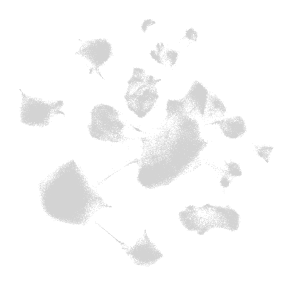

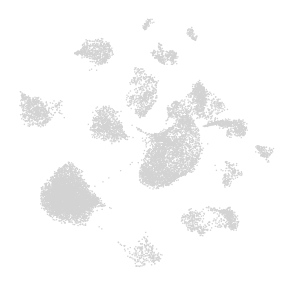

In [335]:
# plot by sequencing batch
sc.pl.umap(adata[adata.obs['seq_batch']=='JBM'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)
sc.pl.umap(adata[adata.obs['seq_batch']!='JBM'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


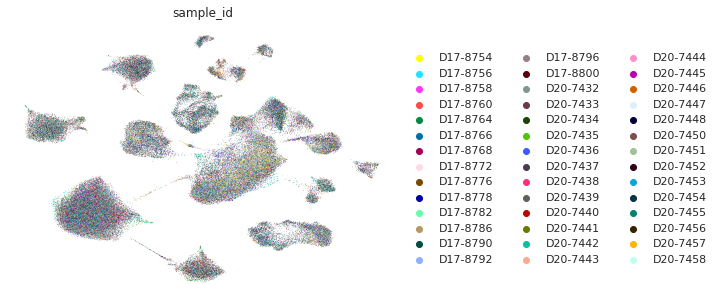

In [336]:
sns.set(rc={'figure.figsize':(7,5)})

sc.pl.umap(adata, color=['sample_id'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


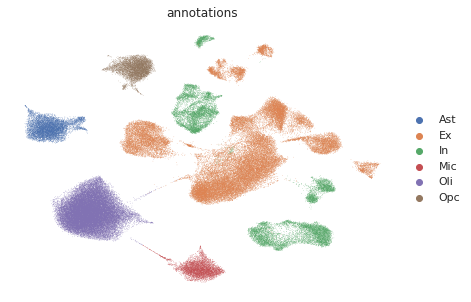

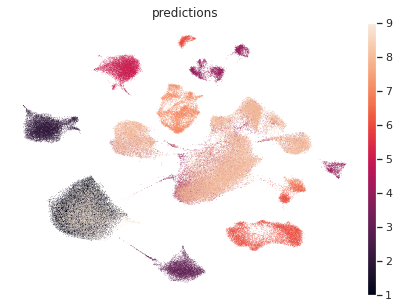

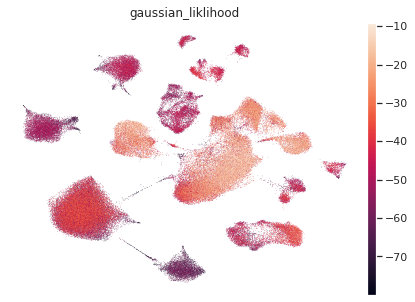

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


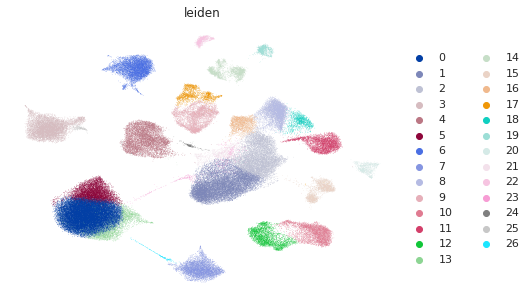

In [337]:
sns.set(rc={'figure.figsize':(7,5)})

# plot UMAPs
sc.pl.umap(adata, color=['annotations'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)
sc.pl.umap(adata, color=['predictions'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)
sc.pl.umap(adata, color=['gaussian_liklihood'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)
sc.pl.umap(adata, color=['leiden'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)

In [338]:
# rank genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is h

In [339]:
# assign marker scores to infer celltypes
markers = pd.read_csv('./processed_data/single_cell/brain_marker_genes.csv')

scores = adata.uns['rank_genes_groups']['logfoldchanges']
names = adata.uns['rank_genes_groups']['names']
pvals = adata.uns['rank_genes_groups']['pvals_adj']

sele_genes = np.array(pd.DataFrame(names)).T
sele_scores = np.array(pd.DataFrame(scores)).T

celltypes = np.unique(markers['major_celltype'])
celltype_scores = np.empty(shape=(sele_scores.shape[0], len(celltypes)))

for cluster in range(sele_scores.shape[0]):
    for i in range(len(celltypes)):
        mark = np.array(markers[markers['major_celltype']==np.unique(celltypes)[i]]['marker'])    
        dictionary = dict(zip(sele_genes[cluster], sele_scores[cluster]))
        S = np.mean([dictionary[x] for x in mark if x in set(dictionary.keys()) ])
        celltype_scores[cluster][i] = S 
        
assignments = np.array([celltypes[np.argmax(x)] for x in celltype_scores])
dictionary = dict(zip(np.arange(len(assignments)), assignments))
adata.obs['Assignment'] = [dictionary[int(x)] for x in np.array(adata.obs['leiden'])]

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


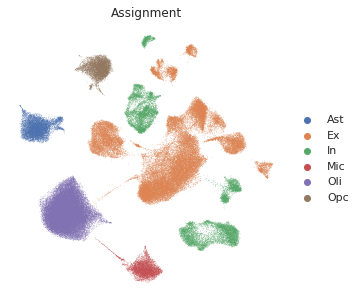

In [340]:
# plot assignments in UMAP space

width = 5
height = 5
sns.set(rc = {'figure.figsize':(width, height)})
out = sc.pl.umap(adata, color=['Assignment'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)

In [341]:
# perform subclustering by major assigned cell type
for i in np.unique(adata.obs['Assignment']):
    print(i)
    sc.tl.leiden(adata, resolution=2, restrict_to=('Assignment', [i]), key_added=i+'_leiden')
#out = sc.pl.umap(adata, color=['sub_leiden'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)


Ast
Ex
In
Mic
Oli
Opc


In [354]:
def compute_thresh(adata, obs_slot, grp_slot):
    df = adata.obs[[obs_slot, grp_slot]].groupby(grp_slot).mean()
    x = df[obs_slot]
    thresh_up = np.mean(x) + 2*np.std(x)
    thresh_down = np.mean(x) - 2*np.std(x)
    return df, thresh_up, thresh_down

def filter_clusters(temp, grp, remove):
    df, up, down = compute_thresh(temp, 'mito_fractions', grp)
    x = list(np.array(df.index)[np.array(df['mito_fractions'])>up])
    for i in x:
        remove.append(i)

    df, up, down = compute_thresh(temp, 'total_counts', grp)
    x = list(np.array(df.index)[(np.array(df['total_counts'])>up) | (np.array(df['total_counts'])<down)])
    for i in x:
        remove.append(i)
    
    i = np.argsort(np.array(temp.obs[grp]))
    temp = temp[i]

    cols = [x in set(remove)for x in np.array(temp.obs[grp])]

    sns.set(rc={'figure.figsize':(20,3)})

    sns.boxplot(x=np.array(temp.obs[grp]), y=np.array(temp.obs['mito_fractions']), hue=cols)
    plt.ylabel('mito_fractions')
    plt.legend([], [], frameon=False)

    plt.show()

    sns.boxplot(x=np.array(temp.obs[grp]), y=np.array(temp.obs['total_counts']), hue=cols)
    plt.ylabel('total_counts')
    plt.legend([], [], frameon=False)

    plt.show()

    b = pd.DataFrame(np.unique(temp.obs[grp], return_counts=True)).T
    b.columns = ['cluster', 'N']
    b['COL'] =[ x in set(remove) for x in b['cluster'] ]
    sns.barplot(data = b, x = 'cluster', y = 'N', hue = 'COL')
    plt.ylabel('N cells')
    plt.legend([], [], frameon=False)

    plt.show()

    unique_samples = list()
    temp2 = temp.obs[[grp, 'sample_id']]
    for i in np.unique(temp2[grp]):
        unique_samples.append(len(np.unique(temp2['sample_id'][temp2[grp]==i])))
    COL = [ x in set(remove) for x in np.unique(temp2[grp])]
    sns.barplot(x = np.unique(temp2[grp]), y = unique_samples, hue = COL)
    plt.ylabel('N individuals')
    plt.legend([], [], frameon=False)


    sns.set(rc={'figure.figsize':(5,3.5)})
    temp.obs['COL'] = np.array([x if x in set(remove) else 'other' for x in temp.obs[grp]])
    sc.pl.umap(temp, color=['COL'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)


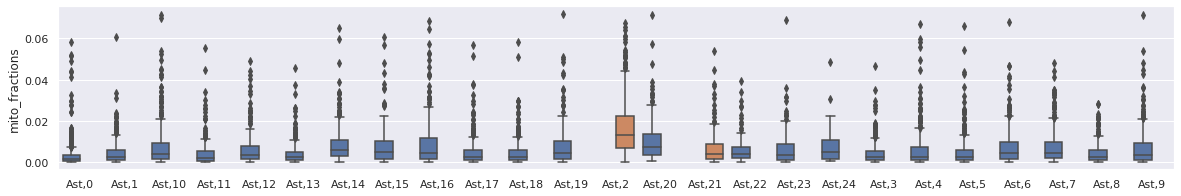

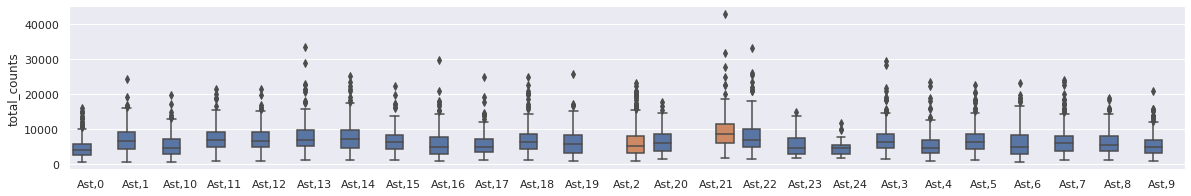

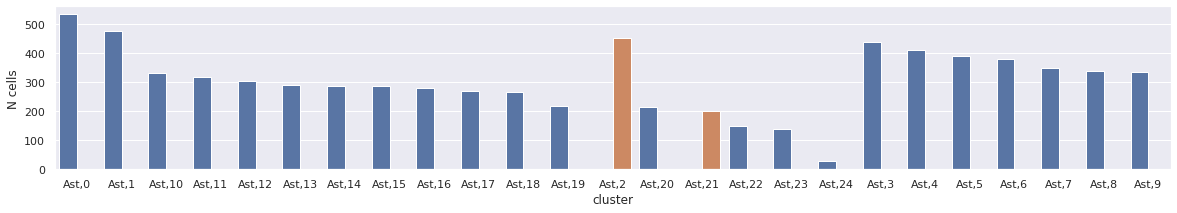

/state/partition1/slurm_tmp/23701570.0.0/ipykernel_3503891/3852509882.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['COL'] = np.array([x if x in set(remove) else 'other' for x in temp.obs[grp]])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


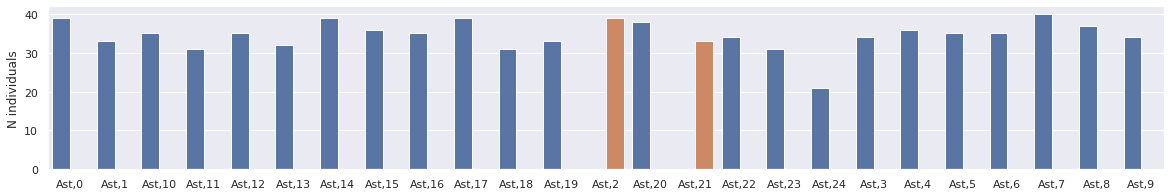

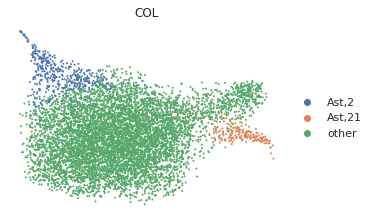

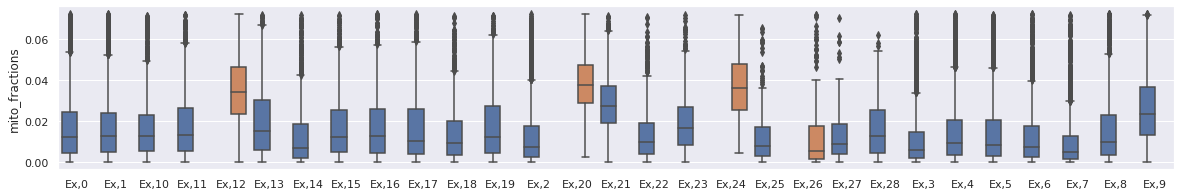

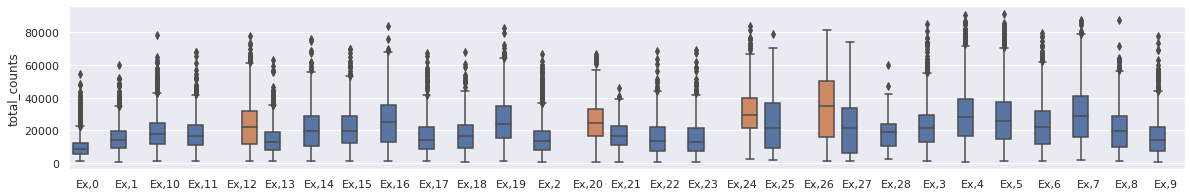

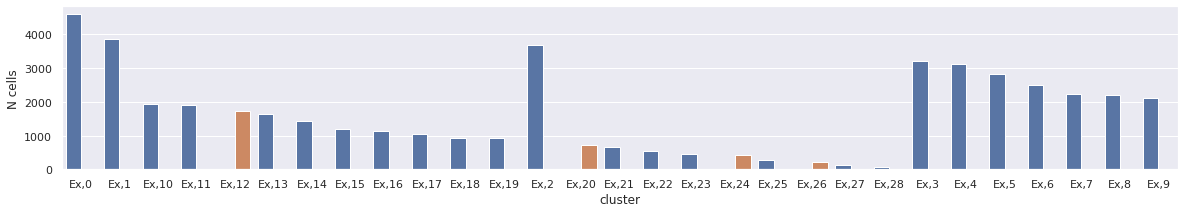

/state/partition1/slurm_tmp/23701570.0.0/ipykernel_3503891/3852509882.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['COL'] = np.array([x if x in set(remove) else 'other' for x in temp.obs[grp]])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


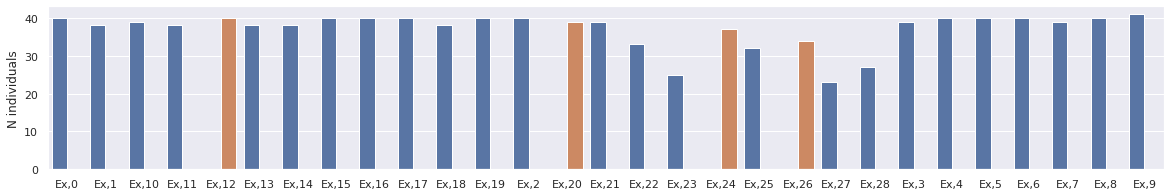

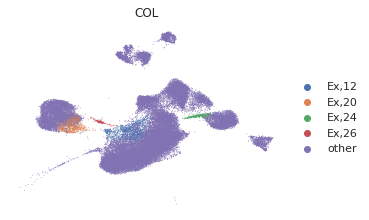

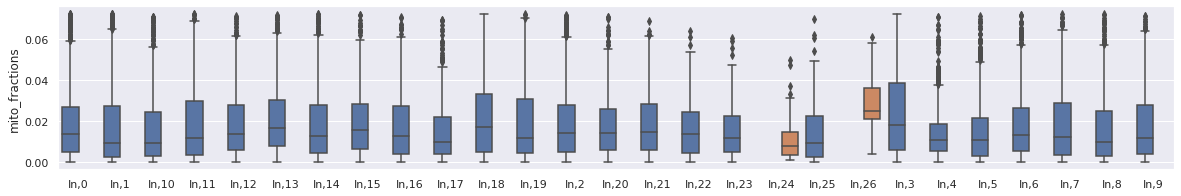

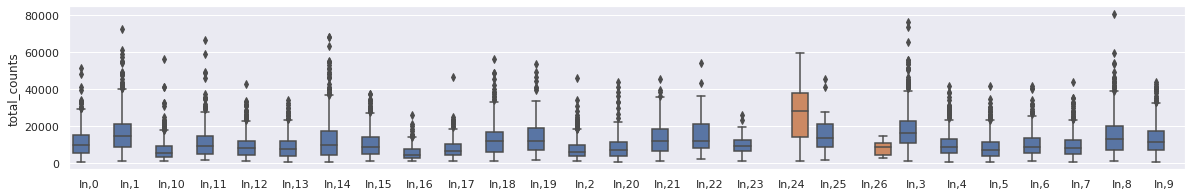

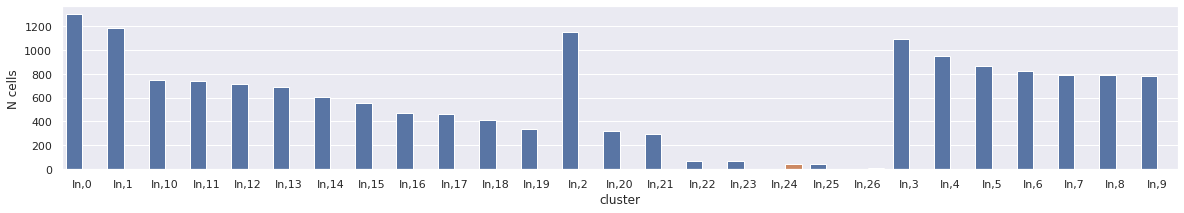

/state/partition1/slurm_tmp/23701570.0.0/ipykernel_3503891/3852509882.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['COL'] = np.array([x if x in set(remove) else 'other' for x in temp.obs[grp]])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


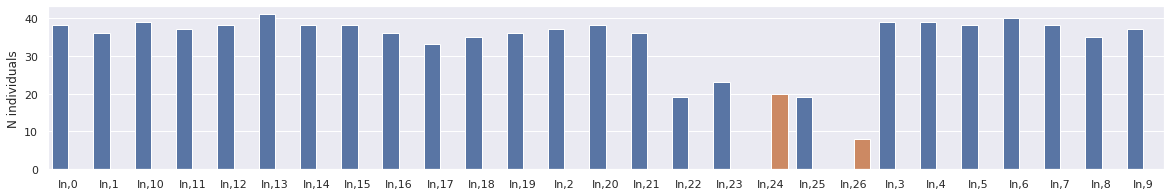

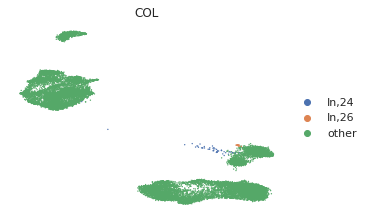

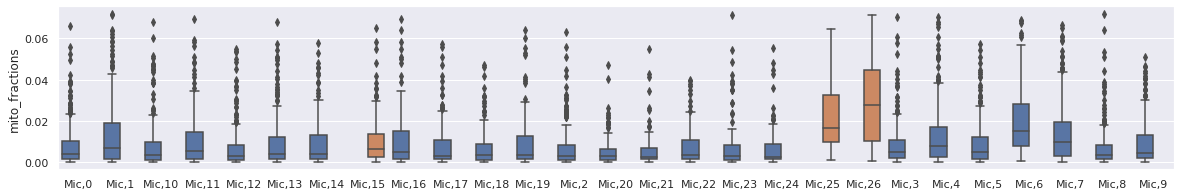

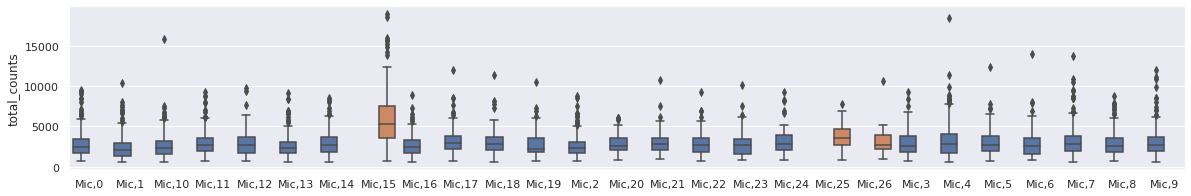

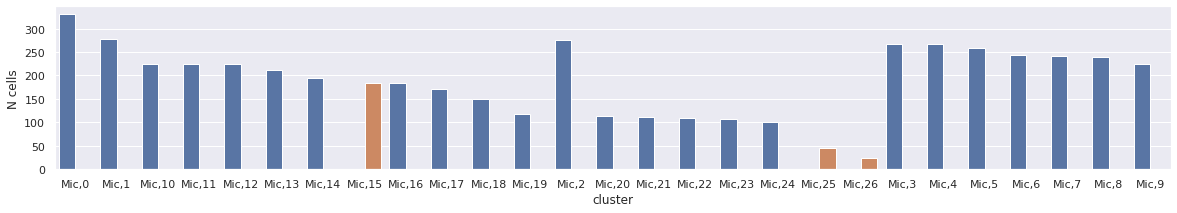

/state/partition1/slurm_tmp/23701570.0.0/ipykernel_3503891/3852509882.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['COL'] = np.array([x if x in set(remove) else 'other' for x in temp.obs[grp]])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


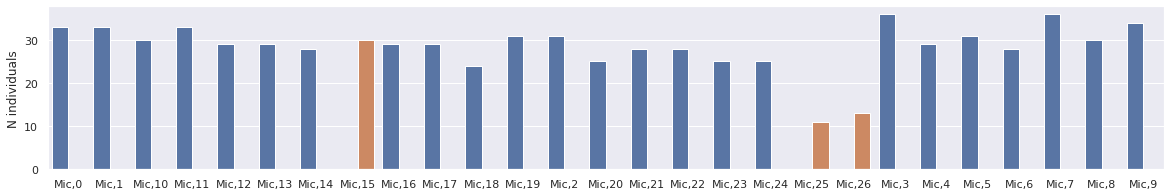

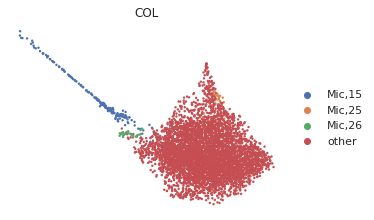

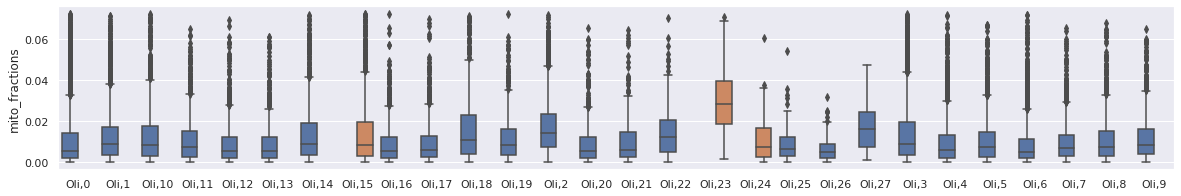

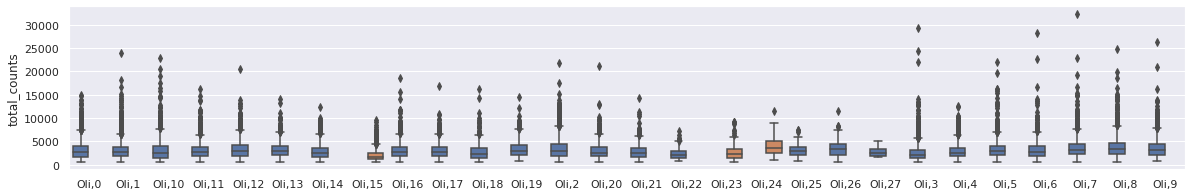

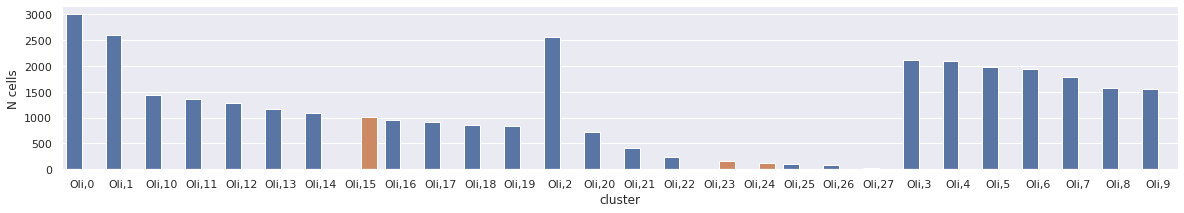

/state/partition1/slurm_tmp/23701570.0.0/ipykernel_3503891/3852509882.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['COL'] = np.array([x if x in set(remove) else 'other' for x in temp.obs[grp]])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


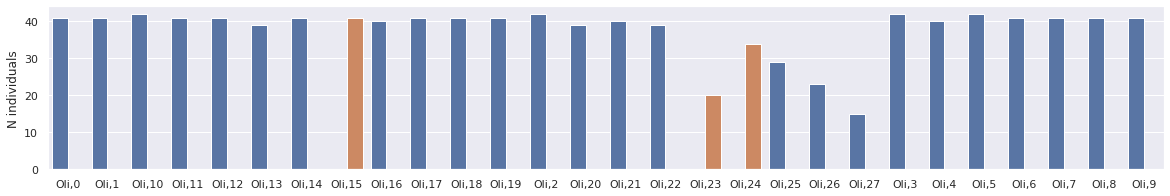

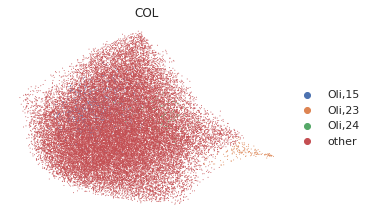

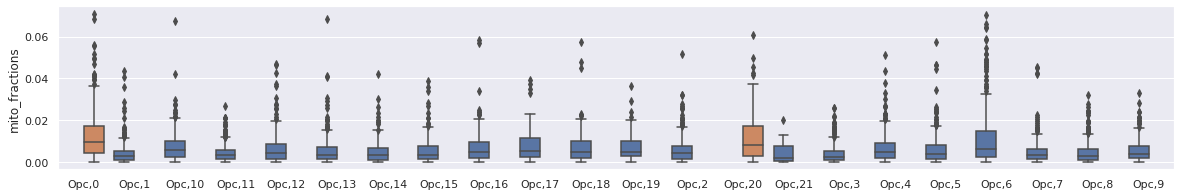

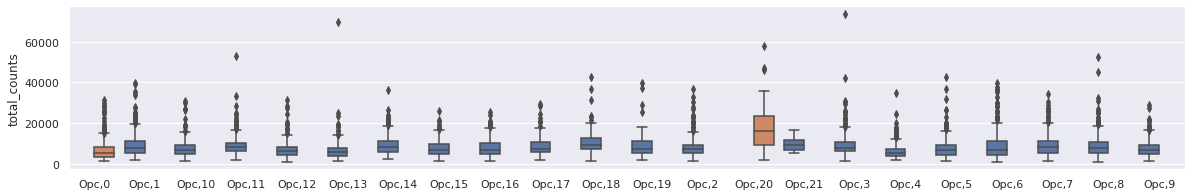

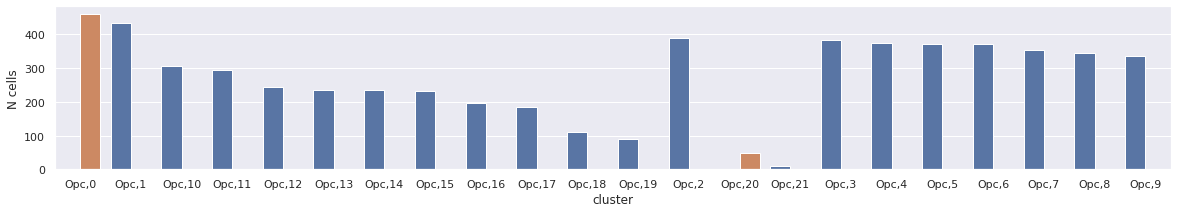

/state/partition1/slurm_tmp/23701570.0.0/ipykernel_3503891/3852509882.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['COL'] = np.array([x if x in set(remove) else 'other' for x in temp.obs[grp]])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


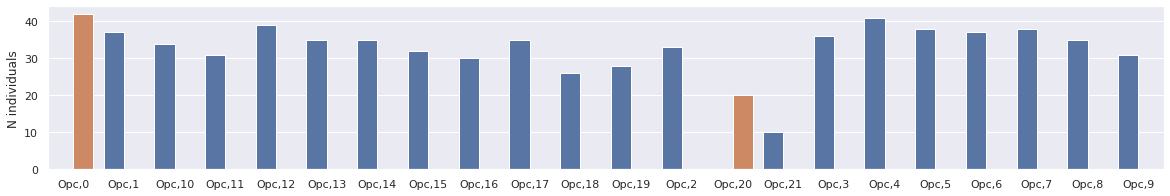

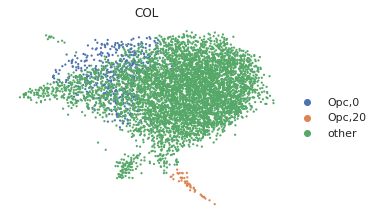

In [355]:
remove = list()
for i in np.unique(adata.obs['Assignment']):
    filter_clusters(adata[adata.obs['Assignment']==i], i+'_leiden', remove)


In [356]:
celltypes

array(['Ast', 'Ex', 'In', 'Mic', 'Oli', 'Opc', 'Vascular'], dtype=object)

In [357]:
out = []
for i in np.unique(adata.obs['Assignment']):
    out.append([x in set(remove) for x in adata.obs[i+'_leiden']])
    
temp = np.vstack(out)
keep = np.sum(temp, axis=0)==0

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


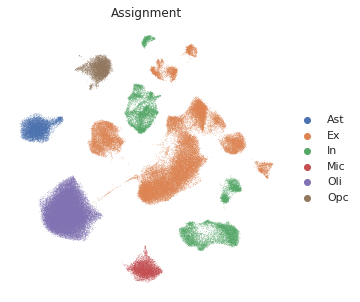

In [358]:
# plot assignments in UMAP space after removing clusters above

width = 5
height = 5
sns.set(rc = {'figure.figsize':(width, height)})
out = sc.pl.umap(adata[keep], color=['Assignment'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


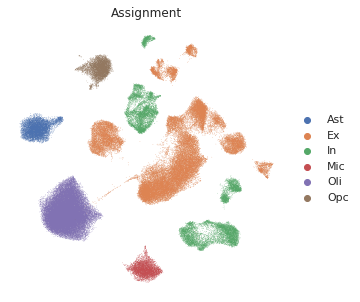

In [359]:
# remove individuals that have very few cells after QC
adata_keep = adata[keep]
tt = adata_keep.obs['sample_id']
assign = adata_keep.obs['Assignment']
x, y = np.unique(tt, return_counts=True)
keep_ind = set(x[y>500])
adata_keep2 = adata_keep[[x in keep_ind for x in adata_keep.obs['sample_id']]]
out = sc.pl.umap(adata_keep2, color=['Assignment'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)

In [360]:
print('neighborhood graph')
sc.pp.neighbors(adata_keep2, use_rep='X_pca', n_pcs=50)
print('UMAP')
sc.tl.umap(adata_keep2, min_dist=0.5, spread=1.0, n_components=2, maxiter=None, alpha=1.0, gamma=1.0, negative_sample_rate=5, init_pos='spectral', random_state=0, a=None, b=None, copy=False, method='umap', neighbors_key=None)

neighborhood graph
UMAP


/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


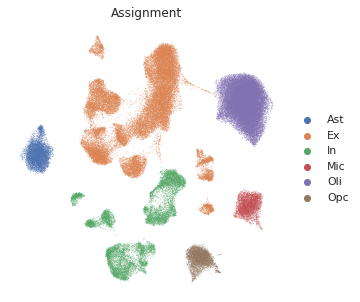

In [361]:
out = sc.pl.umap(adata_keep2, color=['Assignment'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)

In [71]:
# save to sparse matrix (save the new celltype annotations and make sure to subset accordingly)

import scipy.io as sio
from scipy.sparse import csr_matrix

counts_sparse = csr_matrix(counts[index_all][:,index_genes])
logcounts_sparse = csr_matrix(logcounts[index_all][:,index_genes])

sio.mmwrite("./processed_data/single_cell/counts.mtx",counts_sparse)
sio.mmwrite("./processed_data/single_cell/logcounts.mtx",logcounts_sparse)


In [36]:
# save feature data
df = pd.DataFrame(features[index_genes])
df.to_csv("./processed_data/single_cell/rowData.csv")

In [53]:
# save obs data
df = pd.DataFrame(meta[index_all])
df.columns = meta_names
df['annotations2'] = np.array(adata.obs['Assignment'])
df['leiden_clusters'] = np.array(adata.obs['leiden'])
df['x'] = adata.obsm['X_umap'][:,0]
df['y'] = adata.obsm['X_umap'][:,1]   
df.to_csv("./processed_data/single_cell/colData.csv")

In [48]:
# save celltype score info
df = pd.DataFrame(celltype_scores)
df.columns = celltypes
df.to_csv("./processed_data/single_cell/celltype_scores.csv")

In [44]:
# np.save('./processed_data/single_cell/annotations.npy', adata.obs['Assignment'])
# np.save('./processed_data/single_cell/leiden.npy', adata.obs['leiden'])
# np.save('./processed_data/single_cell/scores.npy', celltype_scores)

In [20]:
# # save the coordinates
# import numpy as np
# import pandas as pd
# df = pd.DataFrame(np.load('./processed_data/single_cell/coords.npy'))
# df = df.iloc[index_all]
# df['LoF'] = np.array(META_df['ABCA7LoF'])
# df['seq_batch'] = np.array(META_df['seq_batch'])
# df.to_csv('./processed_data/single_cell/coords.csv')

IndexError: Boolean index has wrong length: 124279 instead of 114274